In [1]:
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

print(torch.__version__)
torch.manual_seed(1337)

2.2.2+cpu


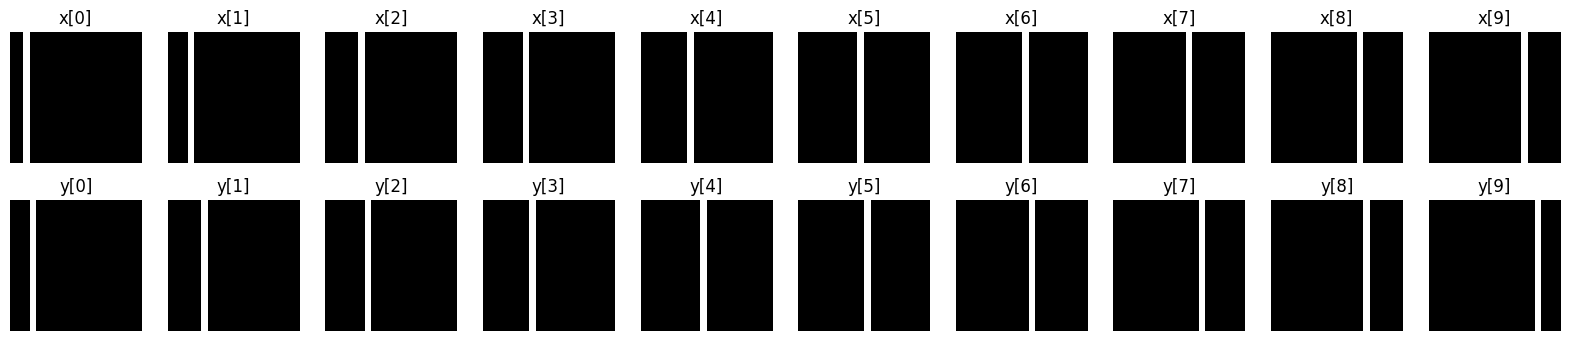

In [3]:
def get_batch(batch_size: int,
              speed: float=None,
              chw: tuple[int, int]=(3, 20, 20),
              seq_len: int=10, ) -> torch.Tensor:
    if speed is None:
        speed = torch.randint(0, chw[2], (batch_size, )).float() / (seq_len + 1)

    all = torch.zeros(batch_size, seq_len + 1, *chw)

    # Create a line and move it from left to right
    for b in range(batch_size):
        # Generate a random starting position for the line
        start_pos = torch.randint(0, chw[2] - int(speed[b] * seq_len), (1,)).item()

        for t in range(seq_len + 1):
            # Calculate the current position of the line
            current_pos = start_pos + int(speed[b] * (t + 1))
            current_pos = min(max(current_pos, 0), chw[2] - 1)  # Ensure line stays within bounds

            # Fill in the pixels of the line
            all[b, t, :, :, current_pos] = 1  # Assuming single channel

    x = all[:, :-1, :, :, :]
    y = all[:, 1:, :, :, :]

    return x, y

# Test the function
batch_size = 2
seq_len = 10
x, y = get_batch(batch_size=batch_size, seq_len=seq_len)

example_x, example_y = x[0], y[0]
# plot each of the 10 frames using matplotlib
fig, axs = plt.subplots(2, seq_len, figsize=(20, 4))
for i in range(seq_len):
    axs[0, i].imshow(example_x[i, 0], cmap='gray')
    axs[0, i].axis('off')
    axs[0, i].set_title(f'x[{i}]')
    axs[1, i].imshow(example_y[i, 0], cmap='gray')
    axs[1, i].axis('off')
    axs[1, i].set_title(f'y[{i}]')

In [4]:
class ConvLSTMCell(nn.Module):
    """Implementation based on the paper: Convolutional LSTM Network: A Machine Learning Approach for Precipitation Nowcasting (https://arxiv.org/abs/1506.04214)."""
    def __init__(self, 
                 in_shape: tuple[int, int, int],
                 out_channels: int,
                 kernel_size: int,
                 activation: str='tanh'):
        """The constructor of the ConvLSTM cell. The cell is supposed to act similarly to the default nn.LSTM cell, but with convolutional layers instead of linear layers.
        
        :param in_shape: The shape of the input tensor (in_channels, height, width).
        :param out_channels: The number of output channels of the cell.
        :param kernel_size: The size of the convolutional kernel.
        :param activation: The activation function of the cell. Can be either 'relu' or 'tanh'.
        """
        super(ConvLSTMCell, self).__init__()

        assert activation in ["relu", "tanh"], "Activation must be either 'relu' or 'tanh'."
        assert kernel_size % 2 == 1, "Kernel size must be odd."

        if activation == "tanh": self.activation = torch.tanh 
        elif activation == "relu": self.activation = torch.relu

        # Single convolutional layer will do all calculations in parallel
        self.conv = nn.Conv2d(in_channels=in_shape[0] + out_channels, 
                              out_channels=4 * out_channels, 
                              kernel_size=kernel_size, 
                              padding=kernel_size // 2)  

        # The biases for the gates
        self.W_ci = nn.Parameter(torch.randn(1, out_channels, in_shape[1], in_shape[2]))
        self.W_co = nn.Parameter(torch.randn(1, out_channels, in_shape[1], in_shape[2]))
        self.W_cf = nn.Parameter(torch.randn(1, out_channels, in_shape[1], in_shape[2]))

    def forward(self, x: torch.Tensor, h_prev: torch.Tensor, c_prev: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """The forward pass of the ConvLSTM cell. The ConvLSTM is supposed to act similarly to the 
        default nn.LSTM cell, but with convolutional layers instead of linear layers.

        :param x: The input tensor of shape (batch_size, in_channels, height, width).
        :param h_prev: The hidden state of the previous time step. (batch_size, out_channels, height, width)
        :param c_prev: The cell state of the previous time step. (batch_size, out_channels, height, width)

        :return: (ct, ht) The cell state and the hidden state of the current time step. Both are of shape (batch_size, out_channels, height, width).
        """
        # Concatenate the input tensor with the hidden state along the channel dimension
        xh = torch.cat([x, h_prev], dim=1) # (batch_size, in_channels + out_channels, height, width)
        # Put the concatenated tensor through the convolutional layer
        # NOTE: The output of the convolutional layer is split into 4 parts: input gate, forget gate, cell state, output gate (the output channels of the conv is 4 * out_channels)
        i_conv, f_conv, C_conv, o_conv = torch.chunk(self.conv(xh), chunks=4, dim=1) # each element is of shape (batch_size, out_channels, height, width)

        it = torch.sigmoid(i_conv + self.W_ci * c_prev) # (batch_size, out_channels, height, width)
        ft = torch.sigmoid(f_conv + self.W_cf * c_prev) # (batch_size, out_channels, height, width)
        ct = ft * c_prev + it * self.activation(C_conv) # (batch_size, out_channels, height, width)
        ot = torch.sigmoid(o_conv + self.W_co * ct) # (batch_size, out_channels, height, width)
        ht = ot * self.activation(ct) # (batch_size, out_channels, height, width)

        return ht, ct

class ConvLSTM(nn.Module):
    def __init__(self, 
                 in_shape: tuple[int, int, int], 
                 out_channels: int, 
                 kernel_size: int, 
                 activation: str='tanh'):
        """The constructor of the ConvLSTM layer. The layer is supposed to act similarly to the default nn.LSTM cell, but with convolutional layers instead of linear layers.
        
        :param in_shape: The shape of the input tensor (in_channels, height, width).
        :param out_channels: The number of output channels of the cell.
        :param kernel_size: The size of the convolutional kernel.
        :param activation: The activation function of the cell. Can be either 'relu' or 'tanh'.
        """
        super(ConvLSTM, self).__init__()
        self.out_channels = out_channels
        self.cell = ConvLSTMCell(in_shape, out_channels, kernel_size, activation)

    def forward(self, x: torch.Tensor, h0c0: tuple[torch.Tensor, torch.Tensor]=None) -> tuple[torch.Tensor, tuple[torch.Tensor, torch.Tensor]]:
        """The forward pass of the ConvLSTM cell. The ConvLSTM is supposed to act similarly to the PyTorch nn.LSTM layer, but with convolutional layers instead of linear layers.
        
        :param x: The input tensor of shape (batch_size, seq_len, in_channels, height, width).
        :param h0c0: The initial hidden and cell states. Both are of shape (batch_size, out_channels, height, width). If None, the initial states are set to zeros.

        :return: output, (h_n, c_n) where:
            - output: The output tensor of shape (batch_size, seq_len, out_channels, height, width).
            - h_n: The hidden state of the last time step. (batch_size, out_channels, height, width).
            - c_n: The cell state of the last time step. (batch_size, out_channels, height, width).
        """
        batch_size, seq_len, _, height, width = x.shape
        if h0c0 is None:
            h0 = torch.zeros(batch_size, self.out_channels, height, width)
            c0 = torch.zeros(batch_size, self.out_channels, height, width)
        else:
            h0, c0 = h0c0
        
        h = h0
        c = c0
        output = []
        for t in range(seq_len):
            h, c = self.cell(x[:, t], h, c)
            output.append(h)
        
        return torch.stack(output, dim=1), (h, c)

class Model(nn.Module):
    def __init__(self, hidden_dim: int, out_channels: int, input_shape: tuple[int, int, int]):
        super(Model, self).__init__()
        self.out_channels = out_channels
        self.lstm = ConvLSTM(input_shape, hidden_dim, 3)
        self.conv = nn.Conv2d(hidden_dim, out_channels, kernel_size=1)
    
    def forward(self, x, target=None):
        h, _ = self.lstm(x) # (batch_size, seq_len, hidden_dim, height, width)
        # NOTE: PyTorch doesn't accept the shape (batch_size, seq_len, channels, height, width) for the convolutional layer, so we need to reshape the tensor
        h = h.view(-1, *h.shape[2:])
        y = self.conv(h).view(x.shape[0], x.shape[1], self.out_channels, x.shape[-2], x.shape[-1])

        if target is not None:
            loss = nn.MSELoss()(y, target)
            return y, loss
        else: 
            return y, None

### Print the number of parameters
NOTE: The original ConvLSTM implementation suffers from large parameter counts whenever the image sizes get too large. This is due to the gates in the ConvLSTMCell since these take on the exact dimensions of the input.

In [5]:
model = Model(50, 3, (3, 1280, 1280))
print(f"Number of parameters (3, 1280, 1280): {sum(p.numel() for p in model.parameters())}")

Number of parameters (3, 1280, 1280): 245855753


In [6]:
model = Model(40, 3, (3, 20, 20))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
print(f"Number of parameters (3, 20, 20): {sum(p.numel() for p in model.parameters())}")

Number of parameters (3, 10, 10): 110203


In [7]:
# Training loop
total_loss = 0

for i in tqdm(range(5000)):
    x, y = get_batch(batch_size=16, chw=(3, 20, 20), seq_len=10)
    optimizer.zero_grad(set_to_none=True)
    y_pred, loss = model(x, y)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

    if i % 500 == 499:
        print(f"Epoch {i} - Loss: {total_loss / 100}")
        total_loss = 0

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch 499 - Loss: 0.09983098701573909
Epoch 999 - Loss: 0.08091029278002679
Epoch 1499 - Loss: 0.07883379109203816
Epoch 1999 - Loss: 0.07813401460647583
Epoch 2499 - Loss: 0.07687995491549372
Epoch 2999 - Loss: 0.07731965745799244
Epoch 3499 - Loss: 0.07681311232969165
Epoch 3999 - Loss: 0.07709391065873206
Epoch 4499 - Loss: 0.0755440048314631
Epoch 4999 - Loss: 0.07703172949142754


Text(0.5, 1.0, 'GT3')

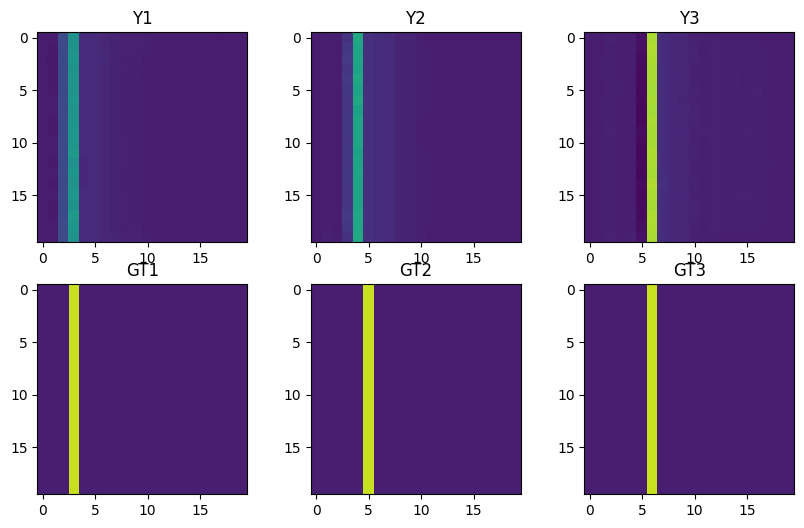

In [11]:
hc = None

data, y = get_batch(1, speed=[1.4], chw=(3, 20, 20), seq_len=10)
with torch.no_grad():
    x = data[0, 0].unsqueeze(0).unsqueeze(0)
    gt1 = y[0, 0].clone()

    inter, hc = model.lstm(x, hc)
    y1 = model.conv(inter.view(1, *inter.shape[2:]))

    x = data[0, 1].unsqueeze(0).unsqueeze(0)
    gt2 = y[0, 1].clone()

    inter, hc = model.lstm(x, hc)
    y2 = model.conv(inter.view(1, *inter.shape[2:]))

    x = data[0, 2].unsqueeze(0).unsqueeze(0)
    gt3 = y[0, 2].clone()

    inter, hc = model.lstm(x, hc)
    y3 = model.conv(inter.view(1, *inter.shape[2:]))

fig, axs = plt.subplots(2, 3, figsize=(10, 6))
vmin, vmax = -0.1, 1.1
axs[0, 0].imshow(y1.squeeze()[0], vmin=vmin, vmax=vmax)
axs[0, 0].set_title("Y1")
axs[0, 1].imshow(y2.squeeze()[0], vmin=vmin, vmax=vmax)
axs[0, 1].set_title("Y2")
axs[0, 2].imshow(y3.squeeze()[0], vmin=vmin, vmax=vmax)
axs[0, 2].set_title("Y3")
axs[1, 0].imshow(gt1.squeeze()[0], vmin=vmin, vmax=vmax)
axs[1, 0].set_title("GT1")
axs[1, 1].imshow(gt2.squeeze()[0], vmin=vmin, vmax=vmax)
axs[1, 1].set_title("GT2")
axs[1, 2].imshow(gt3.squeeze()[0], vmin=vmin, vmax=vmax)
axs[1, 2].set_title("GT3")